# Advanced Machine Learning
# Exercise 5 – NLP models

by  
Tomer Segal, ID301833833  
Millis Sahar, ID300420379  

## Submission instructions

- You should submit 3 files:
  - Two jupyter notebooks (the first one for part 1 and 2, the second one for
  part 3).

    > Indeed you can use an additional .py files for the code to run (including some of the utilities you built). We recommend you to use google colab platform and share with us the final product of your work.

    > The code must be documented in a reasonable way and contain explanations throughout the notebooks regarding the process you implemented. If you use special Python packages (on top of what Anaconda provides) – please document it well.

  - A short PDF document (up to 6 pages) describing the work you did (over
  all parts of the HW), answers to the questions and central insights/conclusions. If space (6 pages) is a limit due to large amount of
  figures/tables – use the notebook to document all work and present only
  the highlights in the submitted PDF.

-  You may submit the exercise in pairs
-  Submission due date: by 18.6.2021, 23:00

# <b><u>Part 3 – classification algorithm</u></b>

Politicians as well as other public figures usually have assistants and staffers that manage most of their social media presence.   

However, like many other norm-defying actions, Donald Trump, the former President of the United States is taking pride in his untamed use of twitter.  

At times during the presidential campaign in 2016 it was hypothesized that Donald Trump is being kept away from his Twitter account in order to avoid unnecessary PR calamities. 

Trump’s tweets are not explicitly labeled (Hilary Clinton, for example, used to sign tweets composed by her by an addition of ‘-H’ at the end of the tweet while unsigned tweets were posted by her staffers). 

It is known, however, that Trump was using an android phone while the staffers were most likely to use an iPhone.   
Luckily, the device information is part of the data available via the
Twitter API, hence it can be used as an authorship label.

**In this part of the HW, you are required to try a number of supervised machine
learning classifiers in order to validate the hypothesis about Trump tweeting habits.**

You may use any algorithm you wish in order to build your classifier.
-  Data - you can find a .tsv file (“train.tsv”) in the course website with the content of the tweets + the label (device type). The data contains 3K tweets. 
- One day before the submission deadline, we will publish a test data (~900
tweets), without the label and will ask you to submit your prediction for this
dataset. Your prediction should be binary (‘iphone’ or ‘android’).




##### prerequisites

In [1]:
!pip install --quiet transformers

##### Imports

In [2]:
# general
import os
import re
import random
import numpy as np
import scipy as sci
import pandas as pd


# time
import calendar
from datetime import datetime


# plots
import seaborn as sns
import matplotlib.pyplot as plt


# NLTK
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS


# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,KFold


# torch
import torch
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available


# drive
from google.colab import drive

Download Stopworlds

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Drive

In [3]:
drive.mount(r'/content/drive/',force_remount=True) 

data_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/AdvancedML/HW5/'

Mounted at /content/drive/


##### Dataset

In [4]:
filepath = data_dir + "train.tsv"
df = pd.read_csv(filepath,sep='\t',names=['ID','User','Tweet','Time','Source'])

df.shape

(2682, 5)

In [5]:
df = df.dropna()
df = df.reset_index(drop=True)
df.shape

(2671, 5)

In [6]:
df['Time'] = pd.to_datetime(df['Time'])

df['year']  = df['Time'].dt.year
df['month'] = df['Time'].dt.month
df['day']   = df['Time'].dt.day
df['hour']  = df['Time'].dt.hour
df['date']  = df['Time'].dt.date

df.shape

(2671, 10)

In [7]:
# 1 - is trump
# 0 - is not trump
df['Label'] = (df.Source == 'android').apply(int)

In [ ]:
df.head()

,ID,User,Tweet,Time,Source,year,month,day,hour,date,Label
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone,2017,3,26,15,2017-03-26,0
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone,2017,3,27,4,2017-03-27,0
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android,2017,2,26,13,2017-02-26,1
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android,2017,2,26,13,2017-02-26,1
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android,2017,2,26,20,2017-02-26,1


##### Set Random Seed

In [8]:
def set_seed(seed: int):
    # random
    random.seed(seed)
    
    # numpy
    np.random.seed(seed)

    # torch
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
         
set_seed(1)

##### Save Results

In [ ]:
df_results = pd.DataFrame(columns=['ModelName','Accuracy'])

def addResult(model_name,acc):
  global df_results
  df_results = df_results.append({'ModelName':str(model_name),'Accuracy':acc},ignore_index=True)

##### Word Cloud

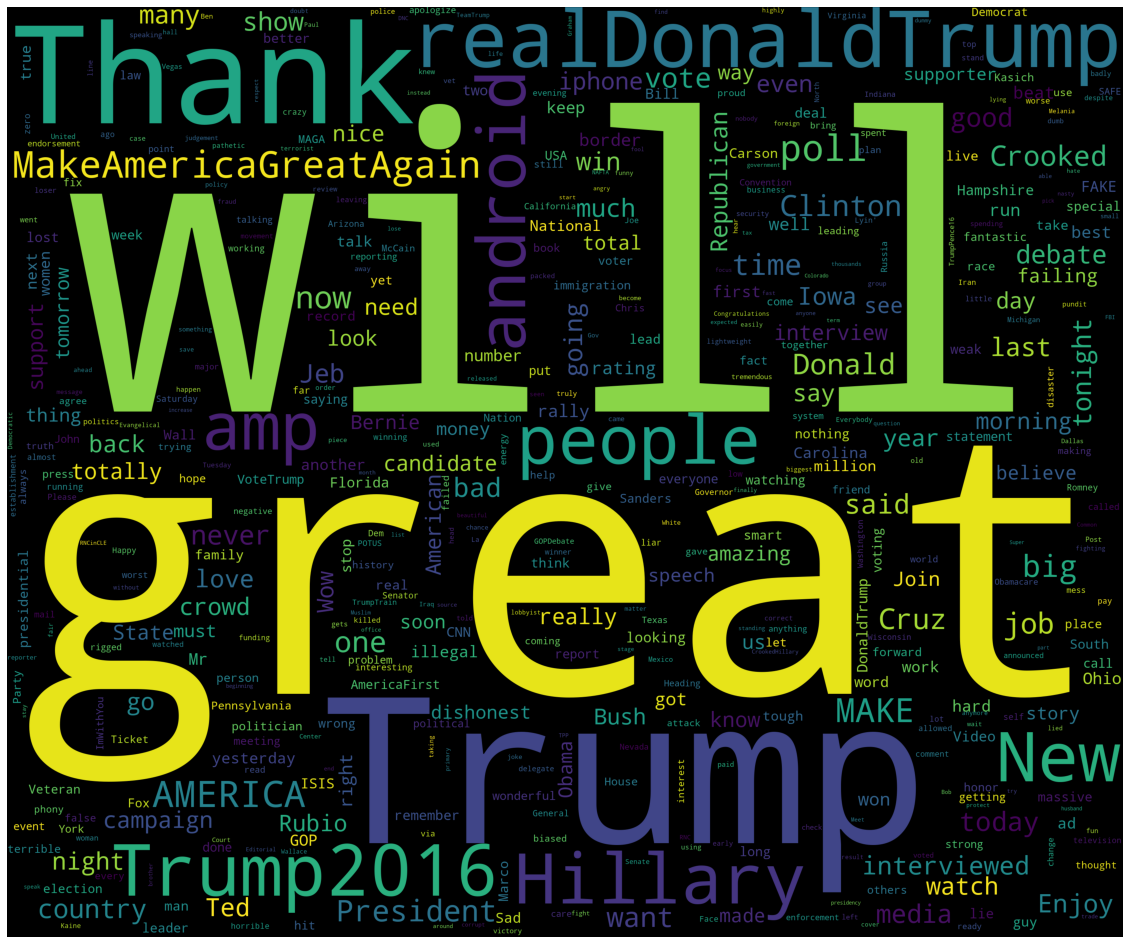

In [ ]:
words = ' '.join(df['Tweet'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,max_words=500,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(cleaned_word)


plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud_words = wordcloud.words_

# s  = pd.Series(wordcloud_words,index=wordcloud_words.keys())
# s.head(5)

# Feature Engineering

##### Tweets

In [ ]:
def tweet_to_words(raw_tweet):
    raw_tweet = " ".join(word for word in raw_tweet.split() if 'http' not in word and not word.startswith('@') and not word.startswith('pic.twitter') and word != 'RT')
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 


df['tweet_length'] = df['Tweet'].map(len)
df['tweet_clean'] = df['Tweet'].map(tweet_to_words)
df['tweet_clean_length'] = df['tweet_clean'].map(len)

##### Hashtags

In [ ]:
def hashtag(tweet):
    with_hashtag = " ".join([word for word in tweet.split() if word.startswith('#')])
    with_hashtag = with_hashtag.lower().split()
    return with_hashtag

df['hashtag'] = df['Tweet'].map(hashtag)
df['hashtag_count'] = df['hashtag'].map(len)

##### Negativeness

In [ ]:
negatives = ['wicked','bad','terrible','fuck','fucking','scary','damage','loss','shatter','shatters',
             'destroying','destroyed','devastating','disruptive','fucked','dead','shattering',
              'victim','alert','warning','evacuation','destructive','flooded','catastrophe','catastrophic',
             'worst','devastation','tornado','danger','dangerous','evacuated','serious',
             'screwed','frightening','flood','flooding','impact','effect','landfall','hitting',
             'influence','devastate','closed','terrifying','disaster','evacuation','evacuations',
             'risky','risk','problem','problems','problematic','need','destructive','disruptive']

def whether_negative(tweet):
    mylist= re.sub("[^a-zA-Z]", " ",tweet).lower().split()
    mylist_wo_neg = [word for word in mylist if word not in negatives]
    return len(mylist) - len(mylist_wo_neg)

df['degree_of_negativity'] = df['Tweet'].map(whether_negative)

##### Include Picture

In [ ]:
# which tweets include a picture
df['picture'] = df['Tweet'].map(lambda x: 1 if 'pic.twitter.com' in x else 0)
df['picture'].sum()

0

##### Include Links

In [ ]:
# which tweets include a link
df['link'] = df['Tweet'].map(lambda x: 1 if 'http' in x else 0)
df['link'].sum()

784

##### Retweet

In [ ]:
# which tweets contain RT (Retweet) 
df['RT'] = df['Tweet'].map(lambda x: 1 if 'RT' in x else 0)
df['RT'].sum()

78

##### About Trump

In [ ]:
# about trump
df['Trump'] = df['Tweet'].map(lambda x: 1 if 'Trump' in x else 1 if 'trump' in x else 1 if 'TRUMP' in x else 0 )
df['Trump'].sum()

992

##### About News

In [ ]:
# about News - '#news' '#foxnews' '#smartnews'
df['news'] = df['Tweet'].map(lambda x: 1 if '#news' in x.lower() else 1 if '#foxnews' in x.lower() else 1 if 'smartnews' in x.lower() else 0)
df['news'].sum()

0

##### Hours

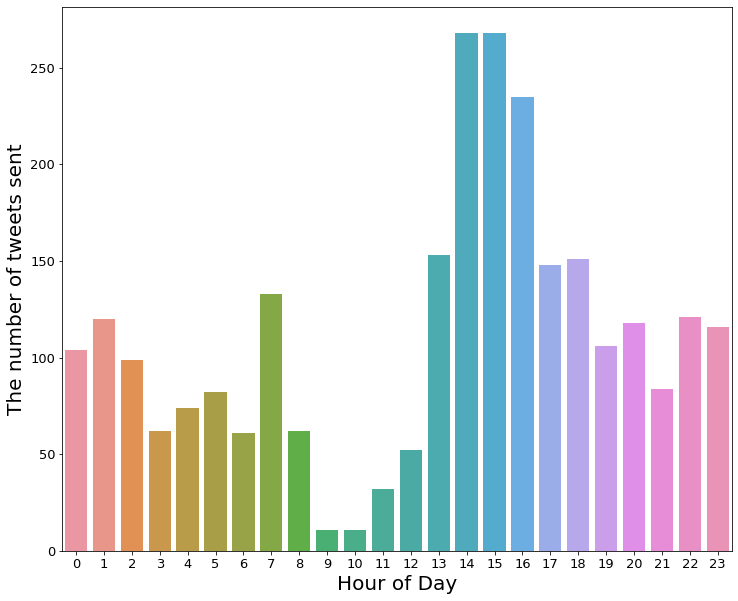

In [ ]:
# hour
plt.figure(figsize=(12,10))
sns.countplot(x="hour",data=df,order=np.sort(df.hour.value_counts().index))
plt.xticks(size=13)
plt.yticks(size=13)
plt.ylabel("The number of tweets sent",size=20)
plt.xlabel("Hour of Day",size=20)
plt.show();

##### Dates

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


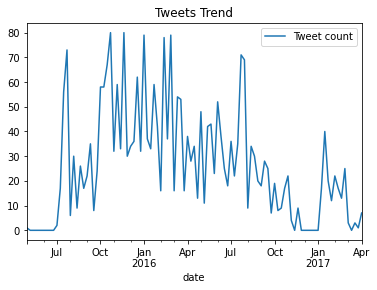

In [ ]:
df['Tweets'] = 1
df2 = df[['date', 'Tweets']]
df2['date'] =  pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)

df2 = df2.resample('W').sum() 

df2['Tweets'].plot(label="Tweet count")
plt.title('Tweets Trend')
plt.legend(ncol=1)
plt.show();

##### Date by Days

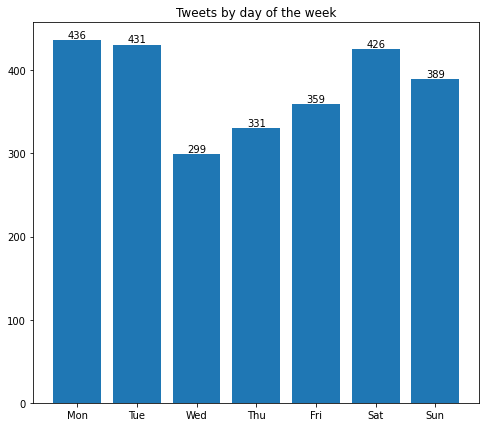

In [ ]:
df_w = pd.to_datetime(df['date']).dt.weekday.value_counts()
df_w.sort_index(inplace=True)
df_w.index.names = ['weekday']
df_sum = df_w.sum(level='weekday')

df_sum.index = list(calendar.day_abbr)

plt.figure(figsize=(8, 7))
plt.bar(df_sum.index, df_sum)
plt.title('Tweets by day of the week')

for x, y in zip(df_sum.index, df_sum):
    plt.text(x, y, y, ha='center', va='bottom')
      
plt.show()

# ML baseline - `Random Forest` , `GradientBoosting`

##### Input Features & Label

In [ ]:
X = df[['year', 'month', 'day', 'hour','tweet_length', 'tweet_clean_length','hashtag_count', 'degree_of_negativity', 'picture', 'link', 'RT', 'Trump', 'news']]
y = df['Label']

##### K-Folds

In [ ]:
kf = KFold(n_splits=4)
kf.get_n_splits(X)

4

##### Train

In [ ]:
rfs = []
xgbs = []

for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index[0], '\t>>', train_index[-1])
    # print("TEST :", test_index[0], '\t>>', test_index[-1],'\n')
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    # RF
    rf = RandomForestClassifier(max_depth=5).fit(X, y)
    score = rf.score(X_test,y_test)
    rfs.append(score)

    # XGBoost
    xgb = GradientBoostingClassifier().fit(X, y)
    score = xgb.score(X_test,y_test)
    xgbs.append(score)

##### RF & GB - Results

We chosen the mean as a result, due to the low level of hypertuning we did.  

In [ ]:
addResult('RandomForest',np.mean(rfs))
addResult('GradientBoosting',np.mean(xgbs))

print('RF:  ', np.mean(rfs),np.max(rfs))
print('XGB: ', np.mean(xgbs),np.max(xgbs))

RF:   0.8524815062528616 0.8712574850299402
XGB:  0.9000338902405085 0.9176646706586826


<br><br><br>
<br><br><br>

# NLP - using only text

Due to the Lack of `CUDA-RAM` we will delete some of the models...
<br><br><br>


##### General Params:

In [9]:
test_size = 0.1
max_length = 512
target_names = ['NTR','TR']

labels = df.Label.to_numpy()

##### Dataset Object

In [10]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)


##### Trainer - params & metrics

In [11]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [12]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
);

<br><br><br>

## BERT model - `bert-base-cased` on *clean_tweets*

In [ ]:
documents = df.tweet_clean.tolist()
train_texts, valid_texts, train_labels, valid_labels = train_test_split(documents, labels, test_size=test_size)

# choose model
model_name = "bert-base-cased"

# tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

# dataset
train_dataset = NewsDataset(train_encodings, train_labels)
valid_dataset = NewsDataset(valid_encodings, valid_labels)

# model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

# trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

# train
trainer.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Step,Training Loss,Validation Loss,Accuracy
200,0.645300,0.510374,0.757463
400,0.437200,0.514625,0.783582
600,0.282600,0.519430,0.817164


***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-200 (score: 0.5103737115859985).


TrainOutput(global_step=604, training_loss=0.4558610813507181, metrics={'train_runtime': 303.6196, 'train_samples_per_second': 31.658, 'train_steps_per_second': 1.989, 'total_flos': 3198238057635840.0, 'train_loss': 0.4558610813507181, 'epoch': 4.0})

In [ ]:
score = trainer.evaluate()
addResult(model_name+':clean_tweets',score['eval_accuracy'])
print(score)

***** Running Evaluation *****
  Num examples = 268
  Batch size = 20


{'eval_loss': 0.5103737115859985, 'eval_accuracy': 0.7574626865671642, 'eval_runtime': 0.2878, 'eval_samples_per_second': 931.282, 'eval_steps_per_second': 48.649, 'epoch': 4.0}


Clean tweets are worse...

In [ ]:
del model
torch.cuda.empty_cache()

<br><br><br>

## DistilBERT model - `distilbert-base-uncased`



In [ ]:
documents = df.Tweet.tolist()
train_texts, valid_texts, train_labels, valid_labels = train_test_split(documents, labels, test_size=test_size)

# choose model
model_name = "distilbert-base-uncased"

# tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

# dataset
train_dataset = NewsDataset(train_encodings, train_labels)
valid_dataset = NewsDataset(valid_encodings, valid_labels)

# model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

# trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

# train
trainer.train()

https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpte7tffti


storing https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99


https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpck9qcis7


storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4


https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpjmgb3xds


storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4


https://huggingface.co/distilbert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpak_v3w43


storing https://huggingface.co/distilbert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
creating metadata file for /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Model config BertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "at

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpqvq0r827


storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.4.attention.v_lin.weight', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'distilbert.transformer.layer.2.attention.k_lin.bias', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'vocab_transform.weight', 'distilbert.transformer.layer.1.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.5.attention.out_lin.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.1.attention.k_lin.weight', 'distilbert.transformer.layer.3.output_layer_norm.weight', 'distilbert.transformer.layer.3.attention.k_lin.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.2.attention.q_lin.bias', 'distilbert.transformer.layer.3.sa_layer_nor

Step,Training Loss,Validation Loss,Accuracy
200,0.570000,0.375311,0.865672
400,0.419100,0.284035,0.888060
600,0.309300,0.342558,0.902985


***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-400 (score: 0.284034788608551).


TrainOutput(global_step=604, training_loss=0.4313522847677698, metrics={'train_runtime': 306.2647, 'train_samples_per_second': 31.385, 'train_steps_per_second': 1.972, 'total_flos': 3232844003745792.0, 'train_loss': 0.4313522847677698, 'epoch': 4.0})

In [ ]:
score = trainer.evaluate()
addResult(model_name,score['eval_accuracy'])
print(score)

***** Running Evaluation *****
  Num examples = 268
  Batch size = 20


{'eval_loss': 0.284034788608551, 'eval_accuracy': 0.8880597014925373, 'eval_runtime': 0.9267, 'eval_samples_per_second': 289.194, 'eval_steps_per_second': 15.107, 'epoch': 4.0}


In [ ]:
del model
torch.cuda.empty_cache()

<br><br><br>

## BERT model - `bert-base-cased`

In [ ]:
# choose model
model_name = "bert-base-cased"

# tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

# dataset
train_dataset = NewsDataset(train_encodings, train_labels)
valid_dataset = NewsDataset(valid_encodings, valid_labels)

# model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

# trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

# train
trainer.train()

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
lo

Step,Training Loss,Validation Loss,Accuracy
200,0.498800,0.289653,0.884328
400,0.247200,0.249171,0.891791
600,0.164600,0.321090,0.906716


***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-400 (score: 0.24917064607143402).


TrainOutput(global_step=604, training_loss=0.3021259448484869, metrics={'train_runtime': 306.2888, 'train_samples_per_second': 31.382, 'train_steps_per_second': 1.972, 'total_flos': 3198238057635840.0, 'train_loss': 0.3021259448484869, 'epoch': 4.0})

In [ ]:
score = trainer.evaluate()
addResult(model_name,score['eval_accuracy'])
print(score)

***** Running Evaluation *****
  Num examples = 268
  Batch size = 20


{'eval_loss': 0.24917064607143402, 'eval_accuracy': 0.8917910447761194, 'eval_runtime': 0.9764, 'eval_samples_per_second': 274.465, 'eval_steps_per_second': 14.338, 'epoch': 4.0}


In [ ]:
del model
torch.cuda.empty_cache()

<br><br><br>

## BERT model - `bert-base-uncased`

In [16]:
documents = df.Tweet.tolist()
train_texts, valid_texts, train_labels, valid_labels = train_test_split(documents, labels, test_size=test_size)

# choose model
model_name = "bert-base-uncased"

# tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

# dataset
train_dataset = NewsDataset(train_encodings, train_labels)
valid_dataset = NewsDataset(valid_encodings, valid_labels)

# model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

# trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

# train
trainer.train()

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a

Step,Training Loss,Validation Loss,Accuracy
200,0.467300,0.281461,0.899254
400,0.261400,0.262824,0.910448
600,0.175600,0.321230,0.910448


***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 268
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-400 (score: 0.2628242075443268).


TrainOutput(global_step=604, training_loss=0.29986755167510337, metrics={'train_runtime': 307.9617, 'train_samples_per_second': 31.212, 'train_steps_per_second': 1.961, 'total_flos': 3232844003745792.0, 'train_loss': 0.29986755167510337, 'epoch': 4.0})

In [ ]:
score = trainer.evaluate()
addResult(model_name,score['eval_accuracy'])
print(score)

***** Running Evaluation *****
  Num examples = 268
  Batch size = 20


{'eval_loss': 0.2628242075443268, 'eval_accuracy': 0.9104477611940298, 'eval_runtime': 0.9307, 'eval_samples_per_second': 287.94, 'eval_steps_per_second': 15.042, 'epoch': 4.0}


In [15]:
# del model
# torch.cuda.empty_cache()

<br><br><br>

## Chosen Model

''

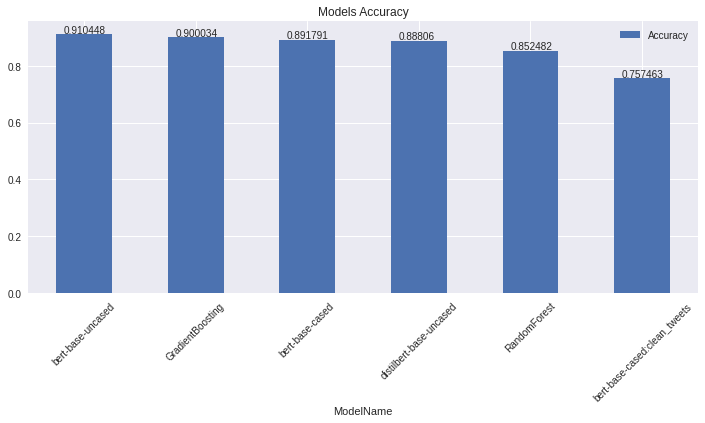

In [ ]:
plt.style.use('seaborn');

ax = df_results.sort_values('Accuracy', ascending=False).plot(x='ModelName',y='Accuracy',kind='bar',figsize=(12,5));
plt.title('Models Accuracy');
plt.xticks(rotation=45);

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),6)), (p.get_x()+0.07, p.get_height() * 1.005))
;

Becuase the `test data` does not contains any information regarding the `publish time` of each tweet - <u>the ML models are not relavent.</u>

<br>

**Our Chosen model is - `bert-base-uncased`**

<br><br><br>

### Predict on test set:

In [46]:
filepath = data_dir + "test_data.tsv"
df_test = pd.read_csv(filepath,sep='\r',names=['ID','Tweet'])

df_test.Tweet = df_test.ID.apply(lambda e: e.split('\t')[1])
df_test.ID = df_test.ID.apply(lambda e: e.split('\t')[0])

df_test

,ID,Tweet
0,768083669550366720,"It is being reported by virtually everyone, an..."
1,768097204376510464,"""Hillary Clinton strongly stated that there w..."
2,768119463421943808,President Obama should have gone to Louisiana ...
3,768125054584393729,"Join me in Tampa, Florida- tomorrow at 1pmE! T..."
4,768196613680398336,"In Austin, Texas with some of our amazing Bord..."
...,...,...
913,722818508665454593,#Trump360 Watch this 360 video of my speech la...
914,722920297393995776,Thank you Indiana! Will be back soon! #Trump20...
915,722967660833722369,Had a meeting with the terrific @GovPenceIN of...
916,722967703313612802,We are going to bring steel and manufacturing ...


In [48]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    
    # perform inference to our model
    outputs = model(**inputs)
    
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    
    # executing argmax function to get the candidate label
    return target_names[probs.argmax()]

df_test['prediction'] = df.Tweet.apply(get_prediction)

In [49]:
df_test

,ID,Tweet,prediction
0,768083669550366720,"It is being reported by virtually everyone, an...",TR
1,768097204376510464,"""Hillary Clinton strongly stated that there w...",NTR
2,768119463421943808,President Obama should have gone to Louisiana ...,TR
3,768125054584393729,"Join me in Tampa, Florida- tomorrow at 1pmE! T...",TR
4,768196613680398336,"In Austin, Texas with some of our amazing Bord...",TR
...,...,...,...
913,722818508665454593,#Trump360 Watch this 360 video of my speech la...,TR
914,722920297393995776,Thank you Indiana! Will be back soon! #Trump20...,TR
915,722967660833722369,Had a meeting with the terrific @GovPenceIN of...,TR
916,722967703313612802,We are going to bring steel and manufacturing ...,TR


In [54]:
df_test[['ID','prediction']].to_csv(data_dir + 'HW5_test_data_predictions_ID301833833_ID300420379.csv',index=False)

In [52]:
df_test.prediction.value_counts()

TR     598
NTR    320
Name: prediction, dtype: int64

<br><br>
Thanks for reading... :)) 